In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## value class implimentation

In [2]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        # Initialize the Value object with data, operation, and label
        self.data = data
        self.grad = 0.0  # Gradient initialized to 0, used in backpropagation
        self._prev = set(_children)  # Set of previous Value objects (used to build computation graph)
        self._backward = lambda: None  # Placeholder for the backward function
        self._op = _op  # Operation that produced this Value (e.g., '+', '*', '**')
        self._label = label  # Label for identifying the Value object
    
    def __repr__(self):
        # String representation of the Value object, including its label and data
        return f"value(data={self.data})"
    
    def __add__(self, other):
        # Called when adding two Value objects or a Value object with a constant
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            # Gradient for addition is propagated equally to both operands
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        
        out._backward = _backward
        return out
    
    def __pow__(self, other):
        # Called when raising a Value object to the power of an int or float
        assert isinstance(other, (int, float)), "Only supporting int/float powers for now"
        out = Value(self.data ** other, (self,), f'**{other}')

        def _backward():
            # Gradient for power operation
            self.grad += other * (self.data ** (other - 1)) * out.grad
        
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        # Called when multiplying two Value objects or a Value object with a constant
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            # Gradient for multiplication, taking into account both operands
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        
        out._backward = _backward
        return out

    def __truediv__(self, other):
        # Called when dividing two Value objects (self / other)
        return self * (other ** -1)  # Division is implemented as multiplication by the inverse
    
    def __rmul__(self, other):
        # Called when a constant is multiplied by a Value object
        return self * other
    
    def __radd__(self, other):
        # Called when a constant is added to a Value object
        return self + other
    
    def __neg__(self):
        # Called when negating a Value object (unary minus)
        return self * -1
    
    def __sub__(self, other):
        # Called when subtracting one Value object from another
        return self + (-other)  # Subtraction is implemented as addition of the negated value

    def tanh(self):
        # Hyperbolic tangent activation function
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, (self,))
        out._op = 'tanh(x)'
        
        def _backward():
            # Gradient for tanh function
            self.grad += (1 - t ** 2) * out.grad
        
        out._backward = _backward
        return out

    def exp(self):
        # Exponential function
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')
        
        def _backward():
            # Gradient for exponential function (e^x)
            self.grad += out.data * out.grad
        
        out._backward = _backward
        return out        
    
    def backward(self):
        # Backpropagation to compute gradients
        self.grad = 1.0  # Start by setting the gradient of the output to 1.0

        # Topological sort to ensure correct order of backpropagation
        topo = []  # List to store the topologically sorted nodes
        visited = set()  # Set to keep track of visited nodes
        
        def build_topo(v):
            # Recursive function to build the topological order
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        
        build_topo(self)  # Build the topological order starting from this Value object

        # Backpropagation through the topologically sorted nodes
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


## helper function

In [3]:
from graphviz import Digraph

def trace(root):
    """
    Builds a set of all nodes and edges in the computational graph.
    This is done by recursively traversing from the `root` node.
    
    Parameters:
    root (Value): The starting node of the graph.
    
    Returns:
    nodes (set): A set containing all unique nodes in the graph.
    edges (set): A set containing all edges (as tuples) between nodes.
    """
    nodes, edges = set(), set()
    
    def build(v):
        if v not in nodes:
            nodes.add(v)  # Add the node to the set
            for child in v._prev:
                edges.add((child, v))  # Add the edge to the set
                build(child)  # Recursively build the graph
    
    build(root)
    return nodes, edges

def draw_dot(root):
    """
    Generates a Graphviz visualization of the computational graph.
    
    Parameters:
    root (Value): The starting node of the graph.
    
    Returns:
    dot (Digraph): A Graphviz Digraph object representing the computational graph.
    """
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # Left to right graph layout
    
    nodes, edges = trace(root)  # Trace the graph starting from root
    
    for n in nodes:
        uid = str(id(n))
        # Create a rectangular ('record') node for each value in the graph
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f }" % (n._label, n.data, n.grad), shape='record')
        if n._op:
            # If the value is a result of an operation, create a node for the operation
            dot.node(name=uid + n._op, label=n._op)
            # Connect the operation node to the value node
            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        # Connect n1 to the operation node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

def print_tree(node, level=0, edges=None):
    """
    Prints a textual representation of the computational graph in a tree structure.
    
    Parameters:
    node (Value): The current node being printed.
    level (int): The current depth level in the tree.
    edges (set): Set of edges in the graph (optional, will be computed if not provided).
    """
    if edges is None:
        nodes, edges = trace(node)  # Trace the graph if edges are not provided
    
    prefix = node._label
    # Print the current node's label, operation, data, and gradient
    print(" " * (level * 8) + prefix + f" {('('+node._op +')') if node._op else '()'} ---> " + f"(D:{node.data:.4f})  (G:{node.grad:.4f})", end='\n\n')
    
    state = 0
    for n1, n2 in edges:
        if n2 == node:
            if not state:
                state += 1
                print_tree(n1, level + 1, edges)
            else:
                print_tree(n1, level + 1, edges)


## main function

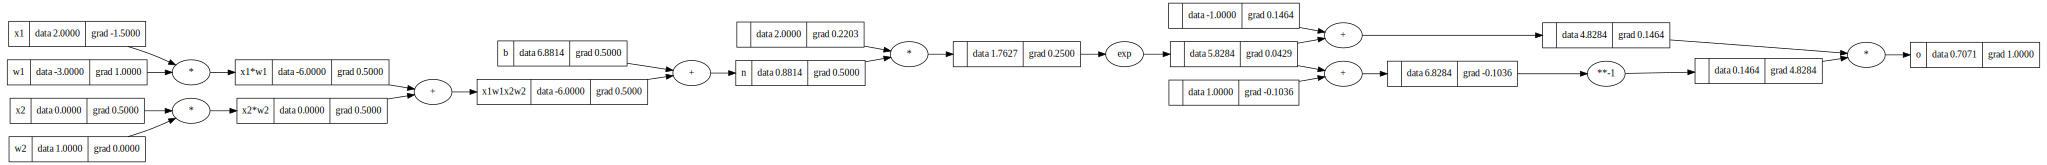

In [16]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias
b = Value(6.8813735870195432, label='b')

# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1._label = 'x1*w1'
x2w2 = x2*w2; x2w2._label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2 ; x1w1x2w2._label = 'x1w1x2w2'
n = x1w1x2w2 + b; n._label = 'n'

# ###############################
# you can impliment tanh directly or you can write manually
e = (2*n).exp();
o = (e -1) / (e + 1)
o._label = 'o'

# o = n.tanh(); o._label = 'o' #this is same as the above three lines

##################################
# backprop
o.backward()
draw_dot(o)

In [25]:
print_tree(o)

o (*) ---> (D:0.7071)  (G:1.0000)

         (**-1) ---> (D:0.1464)  (G:4.8284)

                 (+) ---> (D:6.8284)  (G:-0.1036)

                         () ---> (D:1.0000)  (G:-0.1036)

                         (exp) ---> (D:5.8284)  (G:0.0429)

                                 (*) ---> (D:1.7627)  (G:0.2500)

                                         () ---> (D:2.0000)  (G:0.2203)

                                        n (+) ---> (D:0.8814)  (G:0.5000)

                                                x1w1x2w2 (+) ---> (D:-6.0000)  (G:0.5000)

                                                        x2*w2 (*) ---> (D:0.0000)  (G:0.5000)

                                                                w2 () ---> (D:1.0000)  (G:0.0000)

                                                                x2 () ---> (D:0.0000)  (G:0.5000)

                                                        x1*w1 (*) ---> (D:-6.0000)  (G:0.5000)

                                                         

# using modern framework

In [1]:
import torch

In [10]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()
print(x2.grad.item())

0.7071066904050358
0.5000001283844369


# making neural net

In [4]:
import random
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
    def __call__(self, x):
        # act = sum(wi*xi for wi, xi in zip(self.w, x)) + self.b
        act = sum((wi*xi for wi, xi in zip(self.w, x)),self.b) #starting adding from self.b
        out = act.tanh()
        return out

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    def __call__(self,x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
            
        return x


In [5]:
# single neuron
x = [2.0, 3.0] #data
n = Neuron(2)
n(x)

value(data=-0.9602848142734438)

In [6]:
# single layer neuron
x = [2.0, 3.0] #data
n = Layer(2, 3)
n(x)

[value(data=-0.9789090742847039),
 value(data=-0.9980707282561109),
 value(data=-0.9993776538792827)]

In [5]:
# Multi layer neuron/perceptron
x = [2.0, 3.0, -1.0] #input data
n = MLP(3, [4,4,1])
n(x)

value(data=0.8564261062088303)

In [6]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
ypred = [n(x) for x in xs]
ypred

[value(data=0.8564261062088303),
 value(data=0.8951416184203929),
 value(data=0.8694419548280677),
 value(data=0.854921464446181)]

In [7]:
# loss
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

value(data=7.128036220797252)

In [8]:
loss.backward()

In [20]:
 n.layers[0].neurons[0].w[0].grad

0.049388286023172315

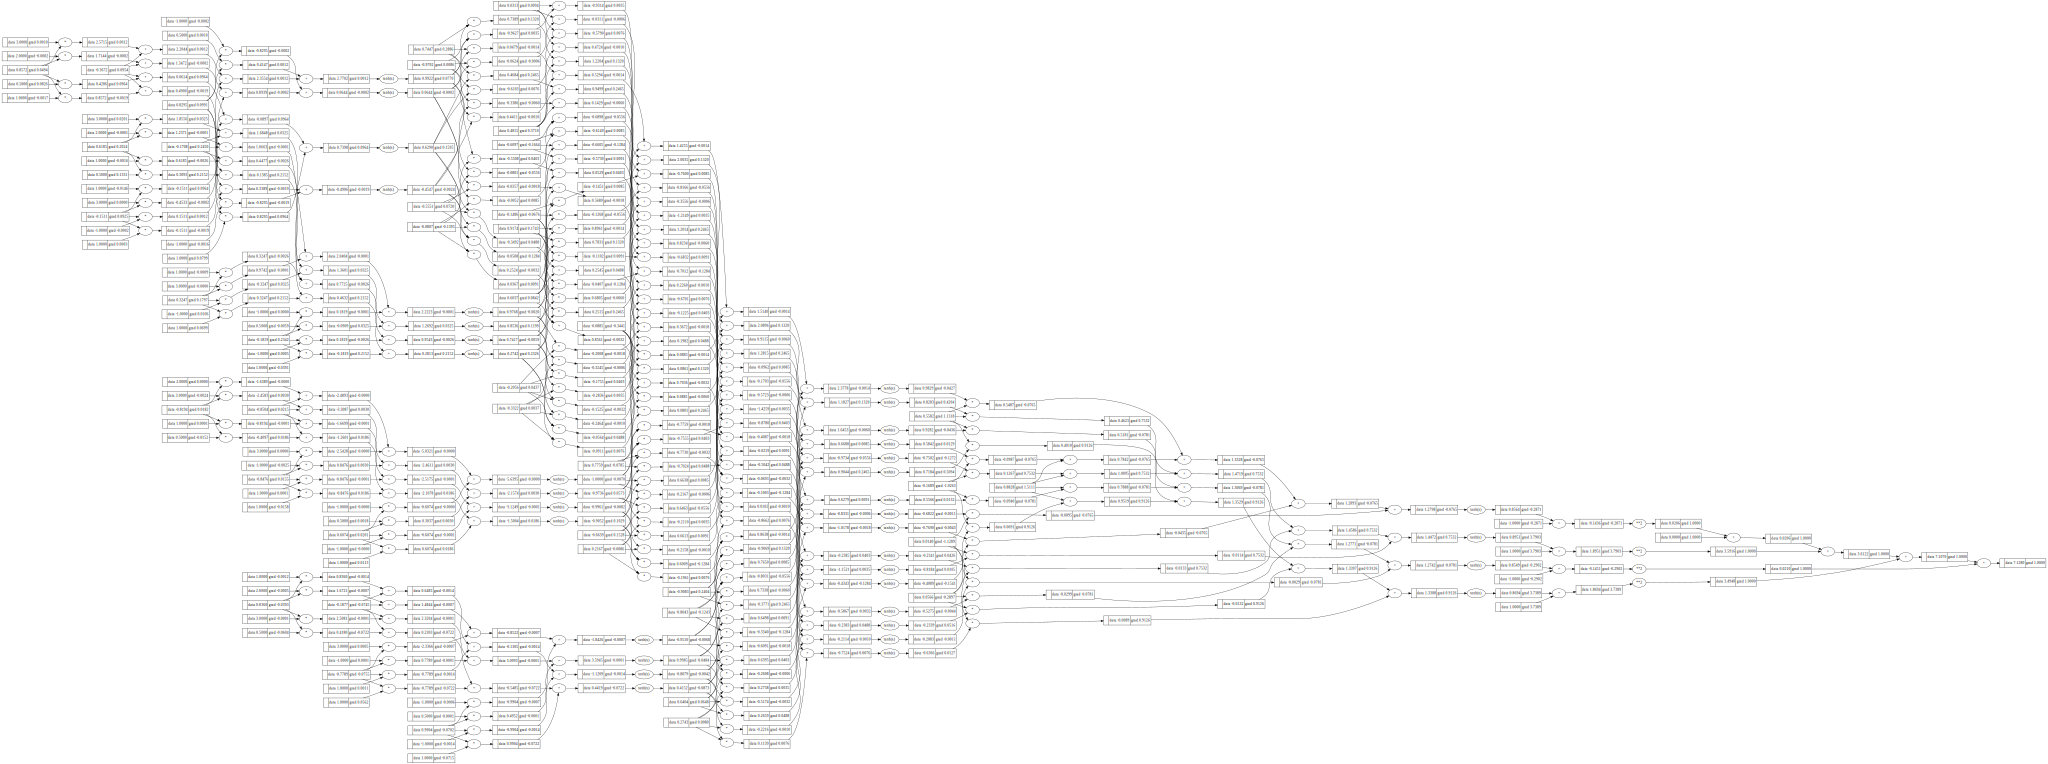

In [10]:
draw_dot(loss)